<h1><center>Length of Stay Project 24h</h1>
<h4>TCSS 555<br>
Spring 2018<br>
Thuan Lam, Tood Robbins, Inno Irving Estrera</h4></center>


<h2>Libraries</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from dateutil.parser import parse
from datetime import datetime

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Global Setup

In [2]:
hoursCheckedIn = 9000              # run pridiction after the patient checkek in <runAt> hours
hoursGranularity = 5    # see the granularity section
numberOfStayRow = -1  # get 5000 rows in the ICU STAYS only. Set numberOfStayRow = -1 if you want to get all rows

## User Defined Functions and Variables

In [3]:
DatetimeFormat = '%Y-%m-%d %H:%M:%S'

def event_time_filter(row):
    proceduretime = datetime.strptime(row.EVENTTIME, DatetimeFormat)
    intime = datetime.strptime(row.INTIME, DatetimeFormat)
    hours = (proceduretime - intime).total_seconds() / 3600.0
    row.hours = hours
    return row

def createEventsTable(dataframe, name, timeColumn):
    print('{} loaded. Shape: {}'.format(dataframe.shape, name))
    dataframe.rename(columns={timeColumn: 'EVENTTIME'}, inplace=True)
    dataframe = pd.merge(dataframe, stays, on='ICUSTAY_ID', how='inner').drop(['LOS','GENDER','AGE'], axis=1)
    dataframe.insert(0,'hours', 0) 
    dataframe = dataframe.apply(lambda row: event_time_filter(row), axis=1)

    # delete hours > hoursCheckedIn
    dataframe = dataframe.loc[dataframe['hours'] <= hoursCheckedIn]

    dataframe.drop(['hours', 'EVENTTIME', 'INTIME'], axis=1, inplace=True)
    print('{} filtered. Shape: {}'.format(name, dataframe.shape))
    return dataframe

## Data

In [4]:
import os 
cwd = os.getcwd()
print('Current folder is {}'.format(cwd))

if os.name == "posix":
    unreadable = set([
        "LABEVENTS.csv",
        "INPUTEVENTS_CV.csv",
        "DATETIMEEVENTS.csv",
        "PRESCRIPTIONS.csv",
        "NOTEEVENTS.csv",
        "OUTPUTEVENTS.csv",
        "CHARTEVENTS.csv",
        "D_LABITEMS.csv",
        "CPTEVENTS.csv"
    ])
    USER_DIR = '/Users/innoestrera/Desktop/mimic3/';
else:
    USER_DIR = 'Data\\';

Current folder is /Users/innoestrera/repositories/Project-2-Length-Of-Stay/phase 2


In [5]:
# Load datasets
stays = pd.read_csv("{}ICUSTAYS.csv".format(USER_DIR))[['ICUSTAY_ID','SUBJECT_ID','INTIME','LOS']]
stays = shuffle(stays)

# delete LOS = null or LOS = 0
stays = stays.fillna(0)
stays = stays.loc[stays['LOS'] > 0]

if numberOfStayRow > 0:
    stays = stays[:numberOfStayRow]

print('ICUStays loaded. Shape: {}'.format(stays.shape))
print(stays.columns.values)
# stays

ICUStays loaded. Shape: (61522, 4)
['ICUSTAY_ID' 'SUBJECT_ID' 'INTIME' 'LOS']


## Hours Granularity

In [6]:
if hoursGranularity == 1: 
    # Option 1: Accuracy +/- 0.1 days = 2 hours and 24 minutes
    # For accuracy, we multiply that by 10. So, LOS=36 means 3.6 days. LOS=113 means 11.3 days
    stays['LOS'] = stays['LOS'].apply(lambda x: int(x * 10))
elif hoursGranularity == 2:
    # Option 2: Accuracy +/- 0.5 days = 12 hours
    # For accuracy, we multiply that by 10, and round up for half-day (0, 5, 10, 15, 20, 25...)
    # For example, LOS=35 means 3.5 days. LOS=110 means 11 days
    stays['LOS'] = stays['LOS'].apply(lambda x: int(round(x * 2, 0) * 5))
elif hoursGranularity == 3:
    # Option 3: Accuracy +/- 1 day = 24 hours
    stays['LOS'] = stays['LOS'].apply(lambda x: int(round(x,0)))
elif hoursGranularity == 4:
    # Option 4: Accuracy +/- 2 day = 48 hours
    # For example, 0 means 0-1 day, 2 means 2-3 days, 4 means 4-5 days, 6 means 6-7 days, ...
    stays['LOS'] = stays['LOS'].apply(lambda x: round(x,0)//2*2)    
elif hoursGranularity == 5:
    # Option 5: Accuracy is a binary choice: Less than 5 days or not
    stays['LOS'] = stays['LOS'].apply(lambda x: 1 if x >= 5 else 0)
# stays

## Patients

In [7]:
patients = pd.read_csv('{}PATIENTS.csv'.format(USER_DIR), encoding='latin1' )[['SUBJECT_ID', 'GENDER', 'DOB']]
print('Patients loaded. Shape: {}'.format(patients.shape))
stays = pd.merge(patients, stays, on='SUBJECT_ID', how='inner').drop(['SUBJECT_ID'], axis=1)

stays.rename(columns={'DOB': 'AGE'}, inplace=True)

# converting gender to a binary 1 or 0
stays['GENDER'] = stays['GENDER'].apply(lambda x: 0 if x == 'F' else 1)

# converting age 
stays['AGE']    = stays['AGE'].apply(lambda x: abs(int(x[:4]) - datetime.now().year)//10 if x.find('-') > 0 else 0)
print('ICUStays joined with Patients. Shape: {}'.format(stays.shape))
print(stays.columns.values)

Patients loaded. Shape: (46520, 3)
ICUStays joined with Patients. Shape: (61522, 5)
['GENDER' 'AGE' 'ICUSTAY_ID' 'INTIME' 'LOS']


In [11]:
recordsToRead=1000000

* <h3>Input_Events_CV

In [8]:
inputeventscv = pd.read_csv('{}INPUTEVENTS_CV.csv'.format(USER_DIR), encoding='latin1', nrows=recordsToRead)[['ICUSTAY_ID', 'STORETIME', 'ITEMID']]
inputeventscv = createEventsTable(inputeventscv, 'INPUTEVENTS_CV', 'STORETIME')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1000000, 3) loaded. Shape: INPUTEVENTS_CV
INPUTEVENTS_CV filtered. Shape: (997467, 2)


* <h3>Procedure_Events

In [12]:
# Load data
procedureevents = pd.read_csv('{}PROCEDUREEVENTS_MV.csv'.format(USER_DIR), nrows=recordsToRead)[['ICUSTAY_ID', 'STARTTIME', 'ITEMID']]
procedureevents = createEventsTable(procedureevents, 'PROCEDUREEVENTS_MV', 'STARTTIME')

(258066, 3) loaded. Shape: PROCEDUREEVENTS_MV
PROCEDUREEVENTS_MV filtered. Shape: (257978, 2)


* <h3>Datetime_Events

In [13]:
# Load data
datetimeevents = pd.read_csv('{}DATETIMEEVENTS.csv'.format(USER_DIR), encoding='latin1', nrows=recordsToRead)[['ICUSTAY_ID', 'STORETIME', 'ITEMID']]
datetimeevents = createEventsTable(datetimeevents, 'DATETIMEEVENTS', 'STORETIME')

(1000000, 3) loaded. Shape: DATETIMEEVENTS
DATETIMEEVENTS filtered. Shape: (997715, 2)


* <h3>Input_Events_MV

In [14]:
# Load data
inputeventsmv = pd.read_csv('{}INPUTEVENTS_MV.csv'.format(USER_DIR), encoding='latin1', nrows=recordsToRead)[['ICUSTAY_ID', 'STARTTIME', 'ITEMID']]
inputeventsmv = createEventsTable(inputeventsmv, 'INPUTEVENTS_MV', 'STARTTIME')

(1000000, 3) loaded. Shape: INPUTEVENTS_MV
INPUTEVENTS_MV filtered. Shape: (999998, 2)


* <h3>Master = Union All Tables 

In [16]:
# If you add a new table, don't forget to put it into the list below 
master = pd.concat([inputeventscv, procedureevents, datetimeevents, inputeventsmv])
print('Master built. Shape: {}'.format(master.shape))
# master

Master built. Shape: (3253158, 2)


* <h3>Pivot All Columns

In [17]:
print('Number of Items/Columns need to be added: ', master.ITEMID.unique().size)
for x in master.ITEMID.unique():
    master[x]=(master.ITEMID==x).astype(int)
    
master = master.groupby(['ICUSTAY_ID']).sum().reset_index()

master = pd.merge(master, stays, on='ICUSTAY_ID', how='inner')
master.drop(['ITEMID','ICUSTAY_ID','INTIME'], axis=1, inplace=True)
print('Master built. Shape: {}'.format(master.shape))
print(master.columns.values)

Number of Items/Columns need to be added:  374
Master built. Shape: (53155, 377)
[30056 30013 30021 30095 30101 30018 30102 30015 30066 30108 30063 30106
 30071 225401 225454 225792 225402 224560 225439 225459 225432 224274
 224263 224385 225752 224275 225400 225462 226237 224264 225451 225448
 225446 225465 225444 225433 221214 224277 223253 227194 225470 225469
 221223 225430 221217 225441 225447 225479 224270 225802 225399 225814
 225805 225445 226236 225794 225202 225442 221255 225476 225434 224273
 225450 224276 225966 225457 225436 224566 221216 225821 225443 226477
 225464 225819 225472 225816 225427 225204 225203 225315 225789 226476
 225967 225437 224267 225468 225817 225474 225449 225475 225429 225205
 225440 225477 227550 225460 225463 227551 225466 221219 225199 224269
 224272 224268 226124 225820 226474 226475 225461 227712 227711 227714
 225428 227713 227715 227719 225467 228129 228125 228128 228127 228130
 228126 228136 228201 228202 228228 228286 228169 3411 5684 5685 5

## Model

In [18]:
# Split-out validation dataset
col = len(master.columns) - 1
array = master.values   #numpy array
X = array[:,0:col]# first N columns
Y = array[:,col]  # LOS column

In [19]:
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)
# print('{}'.format(X_train, Y_train))

[[10  5  5 ...  0  1  7]
 [ 0  0  0 ...  0  0  8]
 [ 0  5  0 ...  0  1  8]
 ...
 [ 0  0  0 ...  0  0  3]
 [ 0  0  0 ...  0  0  3]
 [ 0  0  0 ...  0  1 13]]


In [22]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.911086 (0.003507)
KNN: 0.908452 (0.004385)
CART: 0.885453 (0.003192)
NB: 0.828238 (0.005612)
RF: 0.914895 (0.004589)


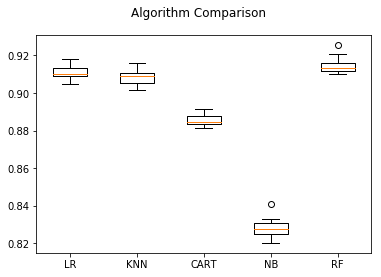

In [23]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [25]:
# Make predictions on validation dataset

messages = []
for name, model in models:
    model.fit(X_train, Y_train)
    prediction = model.predict(X_validation)
    
    accuracyScore = accuracy_score(Y_validation, prediction)
    confusionMatrix = confusion_matrix(Y_validation, prediction)
#     classificationReport = classification_report(Y_validation, prediction)
    
    messages.append('{} accuracy: {}'.format(name, accuracyScore))
    print(confusionMatrix)

print(messages)

['LR accuracy: 0.9070642460728059', 'KNN accuracy: 0.9096039883359985', 'CART accuracy: 0.8814786943843477', 'NB accuracy: 0.8275797196877057', 'RF accuracy: 0.916000376258113']


## Conclusion
#### bla bla bla